# From MARC to LOD: Mining and Publishing Linked Open Bibliographic Data with Python 

## Introduction
Machine Readable Cataloging (MARC) is a widely used standard for the representation and exchange of bibliographic and related information in machine-readable form. (https://www.loc.gov/marc/bibliographic/concise/bdintro.html) Developed by Henriette Avram at the Library of Congress between the 1965 and the 1968, MARC provided a framework for organizing bibliographic data (such as physical description, publication information, notes, and so on) and facilitating the management and retrieval of various bibliographic materials, ranging from textual objects to geographic maps, music, and even software. By the half of the next decade, MARC formats were everywhere and became the _de facto_ standard for structuring and publishing bibliographic data. (Avram, H. D. (1975). MARC; its History and Implications. https://files.eric.ed.gov/fulltext/ED127954.pdf)

The Semantic Web aims to create links between data and make these links understandable by machines. (...)

A related concept is Linked Open Data, which refers to a set of principles that make these links possible and afford accessibility of the
interlinked data on the Web. The bottom line is: the more "things" are connected together, the more powerful, comprehensive and
expandable the data about them can be.

The main benefit of publishing library data as LOD is that it makes data more _attractive_:  it becomes readily available and easier to analyze, combine, integrate, and use for researchers, system developers, librarians, and potentially even for the general public (if done correctly), as consequence of being freed out of conceptual and technical silos (such as MARC). (Best Practices for Library Linked
Open Data (LOD) Publication)

In this tutorial, we will explore a possible way to transition from MARC records to Linked Open Data using Python. We will use the [dardwinslibrary](https://archive.org/details/darwinslibrary) collection, a scholarly edition of Darwin's scientific archive, as an exemplary case study. In particular, we will go through each stage of the process and address its complexities, from collecting MARC records from the Internet Archive to leveraging Python for data cleansing, preparation, and conversion into Linked Open Data. In addition, we will do our best to document the whole process in a FAIR, transparent, and reproducible fashion.

**The code that follows is written using Python X.X.X, Pandas X.X.X and XXXX X.X.X, all running on XXX XX.XX. The complete code can be found on XXXXXX.**

## Know thy MARC

Before getting our hands dirty, we first better get to know what we are dealing with. In particular, we must ask ourselves this question: what is _exactly_ a MARC record?

The MARC standards define three aspects of a MARC record: 
* the **field designations** within each record;
* the **structure** of the record;
* the actual **content** of the record itself.

### Fields
Specific information about the item being described are expressend through **field labels** in a MARC record. These labels can include things like the author, title, publication information, and more. Each field in a record is identified with a straightforward three-digit numeric code that runs from `001` to `999`. For example, field `100` designates the work's `principal author`, field `245` the `title`, and field `260` the `publication information`. Eventual subfields are designated using single letters or numeric labels. Field 260, for instance, has several subfields, like `a` for the `publication location`, `b` for the `publisher`, and `c` for the `publication date`.

### Structure
MARC records are frequently concatenated into a single file and are normally stored and sent as binary files. Every data set has a ISO 2709-compliant framework that describes how the elements are arranged. This structure consists of an initial set of characters that serve as a directory for finding fields and subfields within the record, as well as a marker that indicates the start and finish of each record. 

> An important note that will be useful later: nowadays, MARC records can be represented in XML format thanks to the **MARCXML** schema, developed as an alternative structure in which the fields themselves are represented using XML markup while staying conceptually the same.

### Content
MARC records information about a bibliographic item by emphasizing its metadata over its actual content. As such, it serves as a metadata transfer standard as opposed to a content standard. Only the contents of a few fixed fields are specified by the MARC standards themselves; thus, the specific data entered into each MARC field are usually determined by external standards, such as RDA for physical descriptions and LCSH for subject terms.

## Import needed libraries

In the initial step of our data conversion process, we begin by importing essential Python libraries for carrying out the process:
* `os`: This library provides a platform-independent interface for interacting with the operating system, facilitating tasks such as file and directory operations.
* `re`: Regular expressions are a powerful tool for pattern matching and string manipulation. The 're' library empowers us to efficiently navigate and extract relevant information from our MARC records.
* `pymarc`: Central to our mission, the 'pymarc' library allows us to work with MARC data effortlessly. Its functionality enables parsing, editing, and processing MARC records, essential for our data mining endeavors.
* `internetarchive` (`ia`): Leveraging the 'internetarchive' library grants us seamless access to the Internet Archive, a rich repository of bibliographic records. This connection is fundamental for retrieving the data from the specified collection.
* `pandas` (`pd`): As a robust data manipulation and analysis library, 'pandas' is indispensable for organizing, cleaning, and transforming our data.
* `missingno` (`msgno`): Data quality is paramount, and 'missingno' aids us in visualizing missing data patterns within our dataset.
* `pyarrow` (`pa`): ...
* `parquet` (`pq`): ...
* `json`: ...
* `pathlib`: ...

In [1]:
import os, re, pymarc, json, pathlib
import internetarchive as ia
import pandas as pd
import missingno as msgno
import pyarrow as pa
import pyarrow.parquet as pq
%matplotlib inline
pd.options.display.max_rows = 100

## Data selection

In this initial step, we kick off the process of gathering bibliographic records from the `darwinslibrary` collection on the Internet Archive.

In [2]:
# Define the name of the collection on Internet Archive
collection_name = "darwinslibrary"

# Define the path where the files will be saved
save_path = "marc-files"

# Create the directory if it doesn't exist
if not os.path.exists(save_path):
    os.mkdir(save_path)

# Search for items in the collection
items = ia.search_items(f'collection:{collection_name}')

The variable `collection_name` is set to "darwinslibrary," pointing to the specific collection we are interested in on the Internet Archive. The variable `save_path` determines where the collected MARC files will be stored. If the chosen directory doesn't exist, the code makes it on the fly, keeping things neat and organized. We also make sure the storage directory exists; if it doesn't, the code creates a new one named "marc-files." This ensures a smooth process by providing a clear place for our collected data. Finally, by using the `internetarchive` library, the code searches for items in the specified collection.

## Download the collection

Now, let's get the nitty-gritty, and snag those MARCXML records for each item in our collection.

In [3]:
'''
# For each item, download the MARCXML record
for item in items:

    # Get the item identifier
    identifier = item["identifier"]
    
    # Try to download the record with that identifier, in MARC format, at the `save_path` destination, and do not create a new folder for each file
    try:
        xml_files = ia.download(identifier, 
                                formats=["MARC"], 
                                verbose=True, 
                                destdir=save_path,
                                no_directory=True)

    # If there is a error, print it
    except Exception as e:
        print(e)
    '''

Abercrombie1838wa66W:
 skipping marc-files\Abercrombie1838wa66W_marc.xml, file already exists based on length and date.
Abercrombie1838wa66W_MS:
 skipping marc-files\Abercrombie1838wa66W_MS_marc.xml, file already exists based on length and date.
Agassiz1850up52I:
 skipping marc-files\Agassiz1850up52I_marc.xml, file already exists based on length and date.
Agassiz1850up52I_MS:
 skipping marc-files\Agassiz1850up52I_MS_marc.xml, file already exists based on length and date.
Agassiz2006ft69Y:
 skipping marc-files\Agassiz2006ft69Y_marc.xml, file already exists based on length and date.
Agassiz2006ft69Y_MS:
 skipping marc-files\Agassiz2006ft69Y_MS_marc.xml, file already exists based on length and date.
Barker-Webb1840yf41S:
 skipping marc-files\Barker-Webb1840yf41S_marc.xml, file already exists based on length and date.
Barker-Webb1840yf41S_MS:
 skipping marc-files\Barker-Webb1840yf41S_MS_marc.xml, file already exists based on length and date.
Bechstein1840ob74D:
 skipping marc-files\Bechste

First, we systematically navigate through each item by referencing its unique identifier. Then, we employ the `internetarchive` library to fetch MARCXML records for each item. These records are then stored in the specified directory denoted by `save_path`. The `verbose=True` ensures the system returns a clear view of each execution of the processes. Lastly, we place a error handling mechanism to address any unforeseen issues that may arise during the download process.

## Get the data

In this stage, our focus shifts to extracting essential metadata from the previously acquired MARCXML records. Our objective is to mine pertinent information such as author, title, notes, supplemental material details, and publication specifics.

We start by defining a list in which we will store each record's data.

In [4]:
# Prepare the list of dictionaries
data = []

Then, we will opt for a functional programming approach and define a series of functions, each dedicated in capturing a specific facet of information regarding a record (e.g. its identifier, author, title, etc.). Luckily enough, the input files are written in MARCXML, an XML-based schema that follows MARC structures and terminology, and this makes our extraction job infinitely easier.

In [5]:
def get_author(record):
    '''
    Get the "author" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        author (str): a string containing the name of the author extracted from the MARCXML file.
    '''
    try:
        author = record['100']['a']
        return author
    except Exception as e:
        print(e)

In [6]:
def get_title(record):
    '''
    Get the "title" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        title (str): a string containing the title of the record extracted from the MARCXML file.
    '''
    try:
        title = record['245']['a']
        return title
    except Exception as e:
        print(e)

In [7]:
def get_subtitle(record):
    '''
    Get the "subtitle" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        subtitle (str): a string containing the subtitle of the record extracted from the MARCXML file.
    '''
    try:
        subtitle = record['245']['b']
        return subtitle
    except Exception as e:
        print(e)

In [8]:
def get_pub_place(record):
    '''
    Get the "publication place" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        pub_place (str): a string containing the name of the publication place extracted from the MARCXML file.
    '''
    try:
        pub_place = record['260']['a']
        return pub_place
    except Exception as e:
        print(e)

In [9]:
def get_publisher(record):
    '''
    Get the "publisher" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        publisher (str): a string containing the name of the publisher extracted from the MARCXML file.
    '''
    try:
        publisher = record['260']['b']
        return publisher
    except Exception as e:
        print(e)

In [10]:
def get_pub_date(record):
    '''
    Get the "publication date" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        pub_date (str): a string containing the publication date extracted from the MARCXML file.
    '''
    try:
        pub_date = record['260']['c']
        return pub_date
    except Exception as e:
        print(e)

In [11]:
def get_note(record):
    '''
    Get the "note" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        notes (list): a list of strings containing notes extracted from the MARCXML file.
    '''
    try:
        notes = [note['a'] for note in record.get_fields('500')]
        return notes
    except Exception as e:
        print(e)

In [12]:
def get_ident(lst):
    '''
    Get the "identifier" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        ident (str): a string containing the identifier extracted from the MARCXML file.
    '''
    try:
        for strng in lst:
            if strng.startswith('Identifier'):
                ident = strng[12:]
                return ident
    except Exception as e:
        print(e)

In [13]:
def get_alt_ident(lst):
    '''
    Get alternative identifier metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        ident (str): a string containing an alternative identifier extracted from the MARCXML file.
    '''
    try:
        for strng in lst:
            if strng.startswith('Public number: '):
                ident = strng[15:]
                return ident
    except Exception as e:
        print(e)

In [14]:
def get_supp_material(record):
    '''
    Get the "supplement special issue entry" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        supp_material (str): a string containing the identifier of the supplement special issue entry extracted from the MARCXML file.
    '''
    try:
        supp_material = record['770']['o']
        return supp_material
    except Exception as e:
        print(e)

In [15]:
def get_supp_parent(record):
    '''
    Get the "supplement parent entry" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        supp_parent (str): a string containing the identifier of the supplement parent entry extracted from the MARCXML file.
    '''
    try:
        supp_parent = record['772']['o']
        return supp_parent
    except Exception as e:
        print(e)

For each record, a dictionary is created, encapsulating the metadata attributes we are going to extract. These include:
- `ID`: the identifier of the record;
- `ALT_ID`: an alternative identifier, extracted from the free text in the `note` field;
- `AUTHOR`: the author's full name;
- `TITLE`: the title of the bibliographic work;
- `SUBTITLE`: the subtitle of the bibliographic work;
- `NOTE`: any textual note about the bibliographic work;
- `SUPP_MATERIAL`: the identifier of supplemental material, if any;
- `SUPP_PARENT`: the identifier of the parent record of supplementary material, if any;
- `PUB_PLACE`: the name of the place of publication;
- `PUBLISHER`: the name of the publisher;
- `PUB_DATE`: the full publication date.

The structured dictionaries are systematically appended to the `data` list, creating a comprehensive repository of bibliographic metadata.

In [16]:
# Iterate over the folder
for filename in os.listdir(save_path):

    # Construct the path to the MARCXML file in the current folder
    file_path = os.path.join(save_path, filename)

    # Check if the file exists at that path
    if os.path.isfile(file_path):
        
        # Open the MARCXML file and return the records within it as an array
        with open(file_path, 'rb') as marc_file:
            records = pymarc.marcxml.parse_xml_to_array(marc_file)
    
            # Iterate over the MARC records array and generate a dictionary for each record
            for record in records:
                dct = {
                    'ID': get_ident(get_note(record)),
                    'ALT_ID': get_alt_ident(get_note(record)),
                    'AUTHOR': get_author(record),
                    'TITLE': get_title(record),
                    'SUBTITLE': get_subtitle(record),
                    'NOTE': ' '.join(get_note(record)),
                    'SUPP_MATERIAL': get_supp_material(record),
                    'SUPP_PARENT': get_supp_parent(record),
                    'PUB_PLACE': get_pub_place(record),
                    'PUBLISHER': get_publisher(record),
                    'PUB_DATE': get_pub_date(record)
                }
                data.append(dct)

In order to make the functions work, we need to use `pymarc.marcxml.parse_xml_to_array`, a function from the `pymarc` library that allows parsing an XML file to return the records as an array. Then, each function is called on each record to populate the dictionary structure that in turn is added to the `data` list.

## Data summarization

Our main reason to organize our data into a list of dictionaries is to easily convert it into a **DataFrame**.

A Pandas DataFrame is a two-dimensional, labeled data structure provided by the `pandas` library. It consists of rows and columns, similar to a table or spreadsheet, where each column can have a different data type (e.g., integers, floats, strings) and is labeled with a unique name. DataFrames are versatile data structures commonly used for data manipulation, analysis, and exploration in scientific computing. They offer powerful methods and functions for data indexing, slicing, filtering, grouping, joining, and more, making them a popular choice for working with structured data in Python.

To convert our list of dictionaries into a DataFrame, we just instantiate it like this:

In [110]:
# Create a DataFrame out of the list of dictionaries
df = pd.DataFrame(data)

And here it is! Now that we have organized our data into a DataFrame `df`, we can use a series of utility functionalities to gain a better understanding of it. For example, to have a quick look at the data inside our DataFrame, we can use the `.head()` function to return its first five rows.

In [111]:
# Use .head() and print the first five rows
print(df.head())

                         ID ALT_ID              AUTHOR  \
0     Abercrombie1838wa66W.  0001.  Abercrombie, John.   
1  Abercrombie1838wa66W_MS.   None    Darwin, Charles.   
2         Agassiz1850up52I.  0017.     Agassiz, Louis.   
3      Agassiz1850up52I_MS.   None    Darwin, Charles.   
4         Agassiz2006ft69Y.  0015.     Agassiz, Louis.   

                                               TITLE  \
0  Inquiries concerning the intellectual powers a...   
1  Inquiries concerning the intellectual powers a...   
2  Lake Superior: its character, vegetation, and ...   
3  Lake Superior: its character, vegetation, and ...   
4  Contributions to the natural history of the Un...   

                                            SUBTITLE  \
0                                               None   
1  [Supplementary material in Charles Darwin's co...   
2                                               None   
3  [Supplementary material in Charles Darwin's co...   
4                                 

We can also look at a random sample of rows through the `.sample()` method.

In [112]:
df.sample(50)

,ID,ALT_ID,AUTHOR,TITLE,SUBTITLE,NOTE,SUPP_MATERIAL,SUPP_PARENT,PUB_PLACE,PUBLISHER,PUB_DATE
112,Hooker1838ol53F.,0636.,"Hooker, William Jackson.",The British flora.,None,Signature C. Darwin April 1841. Location: Camb...,None,None,London :,"Longman, Brown, Green & Longmans,",1838.
144,Lamarck2001aj56E_MS.,None,"Darwin, Charles.",Philosophie zoologique. :,[Supplementary material in Charles Darwin's co...,Identifier: Lamarck2001aj56E_MS.,None,Lamarck2001aj56E,None,None,None
128,Jameson1821sp55X_MS.,None,"Darwin, Charles.",Manual of mineralogy. :,[Supplementary material in Charles Darwin's co...,Identifier: Jameson1821sp55X_MS.,None,Jameson1821sp55X,None,None,None
37,Downing1845bh99M.,0345.,"Downing, Andrew Jackson.",The fruits and fruit trees of America.,None,Location: Cambridge. Identifier: Downing1845bh...,Downing1845bh99M_MS,None,London :,"Wiley & Putnam,",1845.
12,Bernhardi1834ez86I.,0098.,"Bernhardi, Johann Jacob.",über den Begriff der Pflanzenart und seine Anw...,None,Location: Cambridge. Identifier: Bernhardi1834...,Bernhardi1834ez86I_MS,None,Erfurt :,"Friedrich Wilhelm Otto,",1834.
172,Milne-Edwards1851ib08L.,0932.,"Milne-Edwards, Henri.",Introduction á la zoologie générale.,None,Location: Cambridge. Identifier: Milne-Edwards...,Milne-Edwards1851ib08L_MS,None,Paris :,"Victor Masson,",1851.
261,Sageret1830bx94H_MS.,None,"Darwin, Charles.",Pomologie physiologique. :,[Supplementary material in Charles Darwin's co...,Identifier: Sageret1830bx94H_MS.,None,Sageret1830bx94H,None,None,None
111,Hoffmann1875jo25R_MS.,None,"Darwin, Charles.",Zur Speciesfrage. :,[Supplementary material in Charles Darwin's co...,Identifier: Hoffmann1875jo25R_MS.,None,Hoffmann1875jo25R,None,None,None
243,Palm1827qc12D.,1051.,"Palm, Ludwig Heinrich.",über das Winden der Pflanzen.,None,Pre-Beagle. Location: Cambridge. Identifier: P...,Palm1827qc12D_MS,None,Tübingen :,"C. Richter,",1827.
213,None,None,"Bastian, Henry Charlton,",The beginnings of life :,"being some account of the nature, modes of ori...",,None,None,London :,"Macmillan,",1872


Nice! We can already notice some interesting quirks in the data. For example:
- identifiers, names and notes seem to follow consistent patterns in their representation (such as `Surname, Name` for `AUTHOR` values);
- `ID` values contain both uppercase and lowercase characters, and end with a period;
- `ALT_ID` values end with a period;
- `AUTHOR` values often end with a period or a comma;
- `SUPP_MATERIAL` and `SUPP_PARENT` contain both uppercase and lowercase characters, and are complementary with each other (the non-null values in one column can fill the null cells in the other column, and vice versa);
- `PUB_PLACE` and `PUBLISHER` values often end with a combination of punctuation and whitespace, and sometimes their null values are expressed through the string "[s.n.]";
- `PUB_DATE` values often end with a period, sometimes they might be enclosed in square parentheses, sometimes they might actually represent a period of time (e.g. two dates connected with an hyphen), and their null values are expressed through the string "n.d."

We are still not done exploring, though. We can use `.shape`, `.info()` and `.describe()` functions to visualize the Dataframe's dimensionality (number of rows and columns), general information, and descriptive statistics.

In [113]:
df.shape

(315, 11)

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             264 non-null    object
 1   ALT_ID         140 non-null    object
 2   AUTHOR         312 non-null    object
 3   TITLE          315 non-null    object
 4   SUBTITLE       148 non-null    object
 5   NOTE           315 non-null    object
 6   SUPP_MATERIAL  132 non-null    object
 7   SUPP_PARENT    124 non-null    object
 8   PUB_PLACE      191 non-null    object
 9   PUBLISHER      183 non-null    object
 10  PUB_DATE       191 non-null    object
dtypes: object(11)
memory usage: 27.2+ KB


In [115]:
df.describe()

,ID,ALT_ID,AUTHOR,TITLE,SUBTITLE,NOTE,SUPP_MATERIAL,SUPP_PARENT,PUB_PLACE,PUBLISHER,PUB_DATE
count,264,140,312,315,148,315,132,124,191,183,191
unique,230,122,133,270,18,240,114,108,34,116,98
top,Kirby2006fz26R.,0843.,"Darwin, Charles.","Ornithological biography, or an account of the...",[Supplementary material in Charles Darwin's co...,,Lyell1837jf09J_MS,Kirby2006fz26R,London :,"John Murray,",1865.
freq,4,4,124,5,124,37,4,4,68,11,8


Splendid. Now we are aware of some other important aspects of our data. For example, considering the number of rows (_and thus values per column_) is 315, we can notice how some values are missing: as a matter of fact, only `TITLE` and `NOTE` are completely populated. Moreover, now we also know that 34 identifiers (264-230) are _not_ unique. Moreover, we also get some interesting tidbits about the most frequent values within the dataset: `Kirby2006fz26R.` (`ID`, 4 times); `Lyell1837jf09J_MS` (`SUPP_MATERIAL`, 4 times); `London` (`PUB_PLACE`, 68 times); `John Murray` (`PUBLISHER`, 11 times); and so on. Of course, these are the values _before_ data cleaning, so this information could still be subject to change...

## Intermission 02: Data documentation and good practices
... but wait! Before getting into data cleaning, we better do our best to follow data management good practices. Themes like FAIR Principles (...) and reproducibility (...) open up whole new worlds to explore, and we certainly do not have the time nor the space to deal with their intricacies right now, but in the meantime it can be useful to pick up from them one suggestion or two about how to make our scientific computing endeavor... well, scientific. 

An excellent way to start documenting what we are doing is by using metadata (supplementary information that describes another object). Metadata is fundamental in data documentation, since it provides context, such as when, where and how the object it refers to was created. Collection and storage of metadata should be considered a key feature to include in data processing endeavors. In particular, we should attach some metadata to our outputs (such as the DataFrame we just created) in order to track the data lifecycle and thus ensuring transparency in all its stages.

But how best to do this?

Unfortunately, Pandas is not that great when it comes to managing metadata, since there is no conventional way to attach it to a DataFrame. So, how do we couple a DataFrame and its relevant metadata together in a portable and durable format?

[This Darren SMith's article](https://towardsdatascience.com/saving-metadata-with-dataframes-71f51f558d8e) provides an excellent approach to implement this by using **Parquet** (a file format for storing tabular data efficiently) and **Arrow** (a mechanism to store tabular data in memory). We will first use Arrow to convert the DataFrame to an Arrow table and then attach metadata to it. This enriched table will then be saved as a Parquet file. Additionally, we will see how to restore the DataFrame and metadata from the saved file.

### Create and insert metadata
For the task at hand, we can express the dataset metadata as a construct that can be easily serialized to JSON (e.g. a Python dictionary) and that follows some predefined conceptual schema. The Dublin Core Metadata Terms [DC] contain a number of useful and recommended properties for providing basic metadata about any publishable Web resource. In particular, we will use the metadata elements `identifier`, `title`, `description`, `creator`, `created`, `subject`, `source`, `license`, and `version` to describe the DataFrame we created.

In [116]:
metadata = {
    'identifier': '',
    'title': 'Darwin\'s library metadata',
    'description': '''
        A dataset made up by the metadata of the scholarly edition of Darwin\'s scientific 
        archive, drawn from https://archive.org/details/darwinslibrary.
        ''',
    'creator': 'Sebastian Barzaghi',
    'created': '2024-01-16',
    'subject': [
        'scientific archive',
        'biology',
        'bibliography'
    ],
    'source': 'https://archive.org/details/darwinslibrary',
    'license': 'https://creativecommons.org/publicdomain/zero/1.0/',
    'version': '0.1.0'
}

The following code follows the instructions in Smith's article in order to couple a DataFrame with its metadata as a Parquet file.

In [117]:
# define unique key for custom metadata
meta_key = 'darwinsarchive.iot'

# use PyArrow to convert the DataFrame into an Arrow table
table = pa.Table.from_pandas(df)

# construct a new Arrow table that is a copy of `table`, 
# but with its native metadata replaced by a combination of 
# the existing metadata and our custom metadata
meta_json = json.dumps(metadata)
existing_meta = table.schema.metadata
combined_meta = {
    meta_key.encode() : meta_json.encode(),
    **existing_meta
}
table = table.replace_schema_metadata(combined_meta)

# save the Arrow table as a `.parquet` file by using the `parquet` library
pq.write_table(table, '2024-01-16_darwinslibrary_v01.parquet', compression='GZIP')

Et voilà! Our DataFrame and its metadata are now coupled together in single Parquet file.

## Data cleaning
Now we can take up from where we left off: cleaning our dataset squeaky clean! Or, at least, we will try our best. 

Data cleaning is a crucial step in the data analysis process, involving the identification, correction, and removal of inaccuracies, inconsistencies, and errors in datasets. This process ensures that the data is accurate, complete, and reliable for further analysis. Common data cleaning tasks include handling missing values, correcting data entry errors, standardizing formats, removing duplicate records, and dealing with outliers. 

In our case, cleaning our data means dealing with all the abnormalities we highlighted in the previous chapters. We will use more Python functions to deal with those by running them for each dictionary in `data`. 

First, we will define the necessary function to eliminate trailing those pesky punctuation and whitespaces.

In [151]:
def clean_trailing_punctuation(value):
    '''
    Clean trailing punctuation from each value in a DataFrame.

    Args:
        value (str): a string value contained in a DataFrame cell.

    Returns:
        value (str): a string containing the value cleaned from any existing trailing punctuation.
    '''
    try:
        value = re.sub(r'^[.,!\[\]?:;]|[.,!\[\]?:;]$', '', value)
        value = value.strip()
    except:
        None
    return value

Also, let us create another function deal with existing values that are used in a non-standard manner, like those "[s.n.]" and "n.d." strings.

In [119]:
def normalize_missing_value(value):
    '''
    Normalizes a missing value in a DataFrame into a None value.

    Args:
        value (str): a string value contained in a DataFrame cell.

    Returns:
        value (str): a string containing a None value if the input value contains "[s.n.]" or "n.d.".
    '''
    try:
        value = re.sub(r'\[s.n.\]|n.d.', 'None', value)
    except:
        None
    return value

In [148]:
def remove_additional_date(value):
    '''
    Normalizes a time period by considering only the start date.

    Args:
        value (str): a string value contained in a DataFrame cell.

    Returns:
        value (str): a string containing only a date.
    '''
    try:
        value_split = value.split('-')
        value = value_split[0]
    except:
        None
    return value

Then, we can use `.apply()` to execute the functions we just defined to the entire DataFrame.

In [152]:
# Apply functions
columns_to_clean = ['ID', 'ALT_ID', 'TITLE', 'AUTHOR', 'PUBLISHER', 'PUB_PLACE', 'PUB_DATE']
columns_to_normalize = ['PUB_PLACE', 'PUBLISHER', 'PUB_DATE']
columns_to_remove_date = ['PUB_DATE']

df[columns_to_clean] = df[columns_to_clean].map(clean_trailing_punctuation)
df[columns_to_normalize] = df[columns_to_normalize].map(normalize_missing_value)
df[columns_to_remove_date] = df[columns_to_remove_date].map(remove_additional_date)

In [141]:
df.sample(10)

,ID,ALT_ID,AUTHOR,TITLE,SUBTITLE,NOTE,PUB_PLACE,PUBLISHER,PUB_DATE,FULL_TITLE,RELATED
296,Weber1850ka76M_MS,None,"Darwin, Charles",Der Taubenfreund,[Supplementary material in Charles Darwin's co...,Identifier: Weber1850ka76M_MS.,None,None,None,Der Taubenfreund. [Supplementary material in C...,Weber1850ka76M
248,Prichard1836as83G,1095,"Prichard, James Cowles",Researches into the physical history of mankind,None,Location: Cambridge. Identifier: Prichard1836a...,London,"Sherwood, Gilbert & Piper",1836,NaN,Prichard1836as83G_MS
182,Muller1838na12J,0977,"Müller, Johannes",Elements of physiology,None,Location: Cambridge. Identifier: Muller1838na1...,London,Taylor & Walton,1838-1842,NaN,Muller1838na12J_MS
146,Le-Couteur2006nw21J_MS,None,"Darwin, Charles",On the varieties of wheat,[Supplementary material in Charles Darwin's co...,Identifier: Le-Couteur2006nw21J_MS.,None,None,None,On the varieties of wheat. [Supplementary mate...,Le-Couteur2006nw21J
177,Mohl1827mc85F_MS,None,"Darwin, Charles",über den Bau und das Winden der Ranken und Sch...,[Supplementary material in Charles Darwin's co...,Identifier: Mohl1827mc85F_MS.,None,None,None,über den Bau und das Winden der Ranken und Sch...,Mohl1827mc85F
220,None,None,"Hooker, William Jackson",The British flora,comprising the phaenogamous or flowering plant...,,London,None,1855,The British flora comprising the phaenogamous ...,None
37,Downing1845bh99M,0345,"Downing, Andrew Jackson",The fruits and fruit trees of America,None,Location: Cambridge. Identifier: Downing1845bh...,London,Wiley & Putnam,1845,NaN,Downing1845bh99M_MS
222,None,None,"Frank, Albert Bernhard",Beiträge zur Pflanzenphysiologie /,None,,Leipzig,None,1868,NaN,None
201,None,None,"Pernety, Antoine Joseph",Journal historique d'un voyage fait aux I^les ...,None,,Berlin,Etienne de Bourdeaux,1769,NaN,None
176,Mohl1827mc85F,0941,"Mohl, Hugo von",über den Bau und das Winden der Ranken und Sch...,None,Pre-Beagle. Location: Cambridge. Identifier: M...,Tübingen,Heinrich Laupp,1827,NaN,Mohl1827mc85F_MS


In [137]:
df['FULL_TITLE'] = df['TITLE'] + ' ' + df['SUBTITLE']

In [132]:
df['RELATED'] = df['SUPP_MATERIAL'].fillna(df['SUPP_PARENT'])
df['RELATED']

0      Abercrombie1838wa66W_MS
1         Abercrombie1838wa66W
2          Agassiz1850up52I_MS
3             Agassiz1850up52I
4          Agassiz2006ft69Y_MS
                ...           
310            Youatt1834ip29P
311         Youatt1837zd27L_MS
312            Youatt1837zd27L
313         Youatt1845wt42Y_MS
314            Youatt1845wt42Y
Name: RELATED, Length: 315, dtype: object

In [135]:
df = df.drop(columns=['SUPP_MATERIAL', 'SUPP_PARENT'])

KeyError: "['SUPP_MATERIAL', 'SUPP_PARENT'] not found in axis"

In [138]:
df.sample(10)

,ID,ALT_ID,AUTHOR,TITLE,SUBTITLE,NOTE,PUB_PLACE,PUBLISHER,PUB_DATE,FULL_TITLE,RELATED
287,Verlot1865ss46T_MS,None,"Darwin, Charles",Sur la production et la fixation des variétés ...,[Supplementary material in Charles Darwin's co...,Identifier: Verlot1865ss46T_MS.,None,None,None,Sur la production et la fixation des variétés ...,Verlot1865ss46T
67,Geoffroy-Saint-Hilaire1854if15J_MS,None,"Darwin, Charles",Histoire naturelle générale des règnes organiq...,[Supplementary material in Charles Darwin's co...,Identifier: Geoffroy-Saint-Hilaire1854if15J_MS.,None,None,None,Histoire naturelle générale des règnes organiq...,Geoffroy-Saint-Hilaire1854if15J
81,Gould1865vh06C,0485,"Gould, John",Handbook to the birds of Australia,None,Location: Cambridge. Identifier: Gould1865vh06...,London,by the author,1865,NaN,Gould1865vh06C_MS
137,Kirby2006fz26R,0729,"Kirby, William",An introduction to entomology,None,"Pre-Beagle. 3rd edn, vol. 1 (1818), 2nd edn, v...",London,"Longman, Hurst, Rees, Orme & Brown",1818-1826,NaN,Kirby2006fz26R_MS
274,Smith1841jg65P,1264,"Smith, Charles Hamilton",Horses,None,Location: Cambridge. Identifier: Smith1841jg65...,Edinburgh,W.H. Lizars,1841,NaN,Smith1841jg65P_MS
148,Loiseleur-Deslongchamps1842qc28A_MS,None,"Darwin, Charles","Considérations sur les céréales, et principale...",[Supplementary material in Charles Darwin's co...,Identifier: Loiseleur-Deslongchamps1842qc28A_MS.,None,None,None,"Considérations sur les céréales, et principale...",Loiseleur-Deslongchamps1842qc28A
90,Gray1872sl90E_MS,None,"Darwin, Charles","Botany for young people: Part 2, How plants be...",[Supplementary material in Charles Darwin's co...,Identifier: Gray1872sl90E_MS.,None,None,None,"Botany for young people: Part 2, How plants be...",Gray1872sl90E
29,Delamer1854bc45Q,0313,"Delamer, Eugene Sebastian (Edmund Saul Dixon)","Pigeons and rabbits in their wild, domestic an...",None,Location: Cambridge. Identifier: Delamer1854bc...,London,G. Routledge & Co.,1854,NaN,Delamer1854bc45Q_MS
103,Hinds1843bk72Y_MS,None,"Darwin, Charles","The regions of vegetation, being an analysis o...",[Supplementary material in Charles Darwin's co...,Identifier: Hinds1843bk72Y_MS.,None,None,None,"The regions of vegetation, being an analysis o...",Hinds1843bk72Y
211,None,None,"Greene, Joseph Reay",Manual of the sub-kingdom Cœlenterata,None,,London,"Longman, Green, Longman and Roberts",1861,NaN,None


### Missing data
Use `missingno` to quickly visualize missing data

<Axes: >

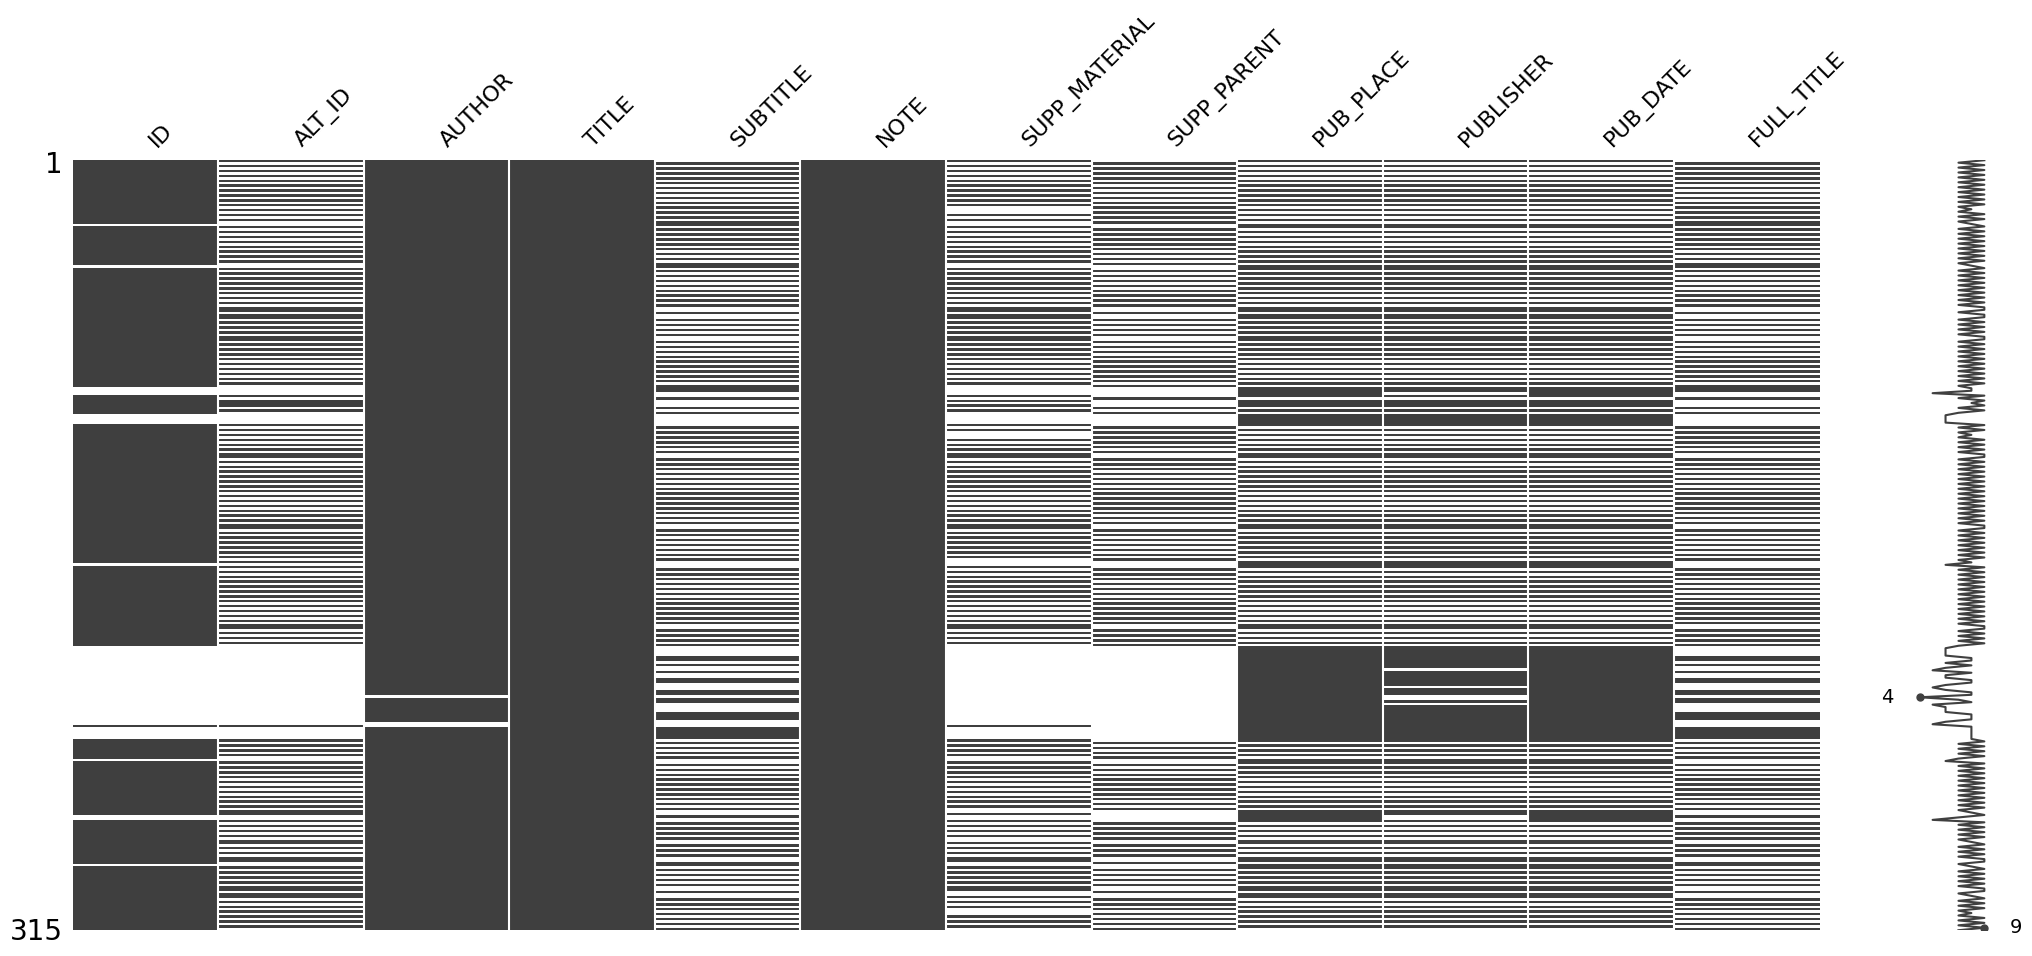

In [124]:
msgno.matrix(df)

In [125]:
df.count() / len(df)

ID               0.838095
ALT_ID           0.444444
AUTHOR           0.990476
TITLE            1.000000
SUBTITLE         0.469841
NOTE             1.000000
SUPP_MATERIAL    0.419048
SUPP_PARENT      0.393651
PUB_PLACE        0.606349
PUBLISHER        0.580952
PUB_DATE         0.606349
FULL_TITLE       0.469841
dtype: float64

There is a gap (nothing dramatic, but still), especially in those columns populated with identifiers

This can be a problem, since identifiers are the main reference mechanism we will use to generate a URI for each record

Let us see in detail those records that are missing their identifiers, among other information

In [153]:
df[df['ID'].isna()]

,ID,ALT_ID,AUTHOR,TITLE,SUBTITLE,NOTE,PUB_PLACE,PUBLISHER,PUB_DATE,FULL_TITLE,RELATED
26,None,None,"Berkenhout, John",Clavis Anglíca linguæ botanicæ,"or, a Botanical Lexicon in which the terms of ...",,London,"Becket, de Houdt, Hawes, Clark & and Collins",1764,"Clavis Anglíca linguæ botanicæ or, a Botanica...",None
43,None,None,"Cleland, John","Evolution, expression, and sensation, cell lif...",y John Cleland,Publisher's advertisements: 16 p. at end.,Glasgow,James Maclehose,1881,"Evolution, expression, and sensation, cell lif...",None
93,None,None,"Murphy, Joseph John",Habit and intelligence in their connexion with...,a series of scientific essays.,Published in two volumes.,London,Macmillan,1869,Habit and intelligence in their connexion with...,None
94,None,None,"Murphy, Joseph John",Habit and intelligence in their connexion with...,a series of scientific essays.,Published in two volumes.,London,Macmillan,1869,Habit and intelligence in their connexion with...,None
95,None,None,"Henle, Jacob",Handbuch der systematischen Anatomie des Menschen,None,,Braunschweig,None,1855,NaN,None
104,None,None,"Vaucher, Jean Pierre Etienne","Histoire physiologique des Plantes d'Europe, o...",None,,Paris,Aurel Freres,1841,NaN,None
105,None,None,"Vaucher, Jean Pierre Etienne","Histoire physiologique des Plantes d'Europe, o...",None,,Paris,Aurel Freres,1841,NaN,None
106,None,None,"Vaucher, Jean Pierre Etienne","Histoire physiologique des Plantes d'Europe, o...",None,,Paris,Aurel Freres,1841,NaN,None
107,None,None,"Vaucher, Jean Pierre Etienne","Histoire physiologique des Plantes d'Europe, o...",None,,Paris,Aurel Freres,1841,NaN,None
165,None,None,"Reade, Winwood",The martyrdom of man /,None,,London,Trübner,1872,NaN,None


In [127]:
df['ID'].isna().value_counts()

ID
False    264
True      51
Name: count, dtype: int64

In [128]:
df['ID'].isna().value_counts(normalize=True)

ID
False    0.838095
True     0.161905
Name: proportion, dtype: float64

In [145]:
df[df['ID'].fillna('').str.contains('noauthor')]

,ID,ALT_ID,AUTHOR,TITLE,SUBTITLE,NOTE,PUB_PLACE,PUBLISHER,PUB_DATE,FULL_TITLE,RELATED
231,noauthor2006yi23A,1117,None,The rabbit book,None,Location: Cambridge. Identifier: noauthor2006y...,London,Journal of Horticulture,None,NaN,noauthor2006yi23A_MS


Now, we can deal with these missing data in various ways

on one hand, identifiers in the `ID` column are quite necessary

on the other hand, `ALT_ID` are nice to have but not necessary

`RELATED` values are very important to connect our data in a graph structure, but it is difficult (if not impossible) to automatically determine whether a record is effectively related to another or not. 

Moreover, we can notice that some of these records with missing identifiers are also repeated, so we also have to take into consideration the possibility of deleting doubles

Now, we can notice that a `ID` value is structured as follows:
> [author's surname][(publication) date][letter][letter][digit][digit][letter][_MS (if Darwin's supplement material)]

So by using the author's surname and the publication date coupled with some randomization mechanism, we can generate unique IDs that follow the same pattern of the others. However, we should also take into consideration further exceptions, namely those rows missing both the identifier _and_ the author (219, 230). In those cases, we will have to resort to using publication date with the randomization mechanism.

In [129]:
metadata_clean = {
    'identifier': '',
    'title': 'Darwin\'s library',
    'description': '''
        A clean dataset consisting in the metadata of the scholarly works in Darwin\'s scientific 
        archive, drawn from https://archive.org/details/darwinslibrary.
        ''',
    'creator': 'Sebastian Barzaghi',
    'created': '2024-01-16',
    'subject': [
        'scientific archive',
        'biology',
        'bibliography'
    ],
    'source': 'https://archive.org/details/darwinslibrary',
    'license': 'https://creativecommons.org/publicdomain/zero/1.0/',
    'version': '0.1.0'
}

In [130]:
pq.write_table(table, '2024-01-16_darwinslibrary_v02.parquet', compression='GZIP')

With all this in mind, we can proceed with data cleaning. but how

given our need to both clean and reconcile our data, taking a small step back from python for a moment might be a good idea

we can use openrefine?